In [1]:
import os
import random
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.optimize import minimize

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
base_context = 'fivethirtyeight'

def fast_hist(data, n=30, ax=None, figsize=(12, 4), title='', alpha=1, label='', new_figure=True):    
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        data.hist(bins=n, ax=ax, figsize=figsize, alpha=alpha, label=label)
        plt.title(title);
        
def fast_plot(data, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):    
    data = data.rolling(rolling).mean()    
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(data.index, data, alpha=alpha)
        plt.plot(data.index, data, linewidth=0.5, label=label)
        if title is not None:
            plt.title(title)   
            
def display_series(data, name=' '):
    df = data.to_frame().T
    df.index = [name]
    display(df)

# Загрузка данных

In [4]:
train_features = pd.read_csv('data/train_features.csv', index_col='timestamp', parse_dates=True)
train_targets = pd.read_csv('data/train_targets.csv', index_col='timestamp', parse_dates=True)
test_features = pd.read_csv('data/test_features.csv', index_col='timestamp', parse_dates=True)
submission = pd.read_csv('data/sample_submission.csv', index_col='timestamp', parse_dates=True)
print('Train features shape:', train_features.shape)
print('Train targets shape:', train_targets.shape)
print('Test features shape:', test_features.shape)
print('Submission shape:', submission.shape)

Train features shape: (5808, 10)
Train targets shape: (5808, 4)
Test features shape: (3984, 10)
Submission shape: (3984, 4)


# Фильтрация №1

In [5]:
%%time
features = ['A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10']
targets = train_targets.columns
train = pd.concat([train_features, test_features])

train = train.fillna(method='ffill')
train['A'] = train['A_rate'].cumsum()
train['B'] = train['B_rate'].cumsum()

train = pd.merge(train, train_targets, left_index=True, right_index=True, how='outer')
train = train['2020-01-01 04:30:00':]

Wall time: 18 ms


In [6]:
train_mask = ((train.index > '2020-02-15') & (train.index < '2020-03-19') & (train[targets].sum(axis=1) > 0)) | \
    ((train.index > '2020-03-22') & (train.index < '2020-04-06') & (train[targets].sum(axis=1) > 0))

train_targets_mask = ((train_targets.index > '2020-02-15') & (train_targets.index < '2020-03-19') &
                      (train_targets.sum(axis=1) > 0)) | \
                     ((train_targets.index > '2020-03-22') & (train_targets.index < '2020-04-06') & 
                      (train_targets.sum(axis=1) > 0))

### Коррекция колебаний

In [7]:
def get_threshold(data, quantiles):
    return data.diff().quantile(quantiles).abs().max()

def correct_data(data, quantiles_data, quantiles, rolling):
    treshold = get_threshold(quantiles_data, quantiles)
    data = data.copy()
    rolling_data = data.rolling(rolling).mean()
    mask = ((data.diff().abs() > treshold) | (data.diff(periods=2).abs() > treshold * 2)) 
    data[mask] = rolling_data[mask]
    return data  

In [8]:
train_corrected = train.copy()
for feature in features:
    train_corrected[feature] = correct_data(train_corrected[feature], 
                                            train_corrected[feature]['2020-01':'2020-03'], [0.05, 0.95], 10)  

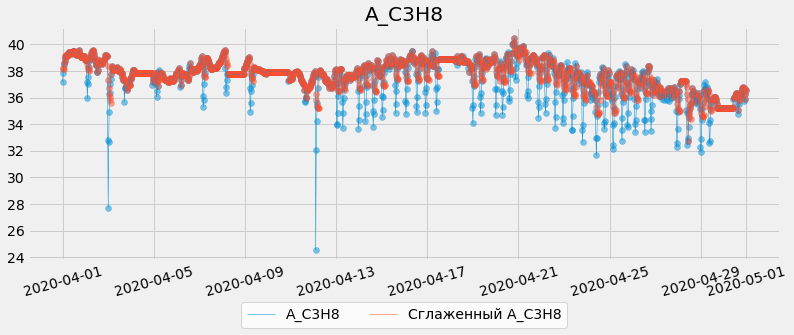

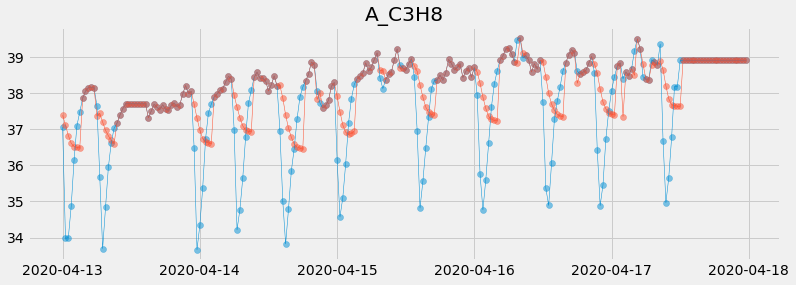

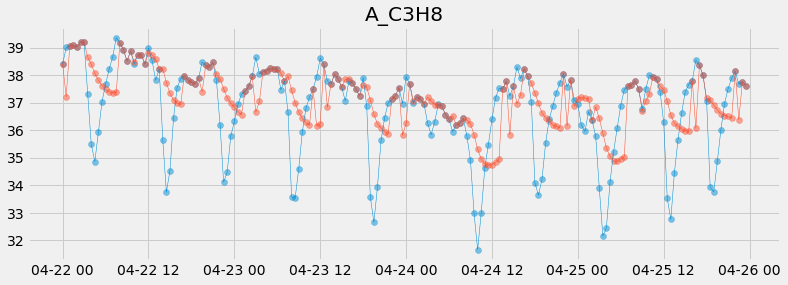

In [11]:
fast_plot(train['A_C3H8']['2020-04':'2020-04'], title='A_C3H8', label='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04':'2020-04'], new_figure=False, label='Сглаженный A_C3H8')
plt.xticks(rotation=15);
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.15), fontsize=14)
plt.show()

fast_plot(train['A_C3H8']['2020-04-13':'2020-04-17'], title='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04-13':'2020-04-17'], new_figure=False)

fast_plot(train['A_C3H8']['2020-04-22':'2020-04-25'], title='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04-22':'2020-04-25'], new_figure=False)

### Коррекция выбросов

In [13]:
train = train_corrected.copy()

In [14]:
low = 0.005
high = 0.995
A_C2H6_quantiles = train['A_C2H6'][train_mask].quantile([low, high]).values
A_C3H8_quantiles = train['A_C3H8'][train_mask].quantile([low, high]).values
A_iC4H10_quantiles = train['A_iC4H10'][train_mask].quantile([low, high]).values
A_nC4H10_quantiles = train['A_nC4H10'][train_mask].quantile([low, high]).values
print(A_C2H6_quantiles)
print(A_C3H8_quantiles)
print(A_iC4H10_quantiles)
print(A_nC4H10_quantiles)

train['A_C2H6'][(train['A_C2H6'] < A_C2H6_quantiles[0]) | (train['A_C2H6'] > A_C2H6_quantiles[1]) ] = np.NaN
train['A_C3H8'][(train['A_C3H8'] < A_C3H8_quantiles[0]) | (train['A_C3H8'] > A_C3H8_quantiles[1])] = np.NaN
train['A_iC4H10'][(train['A_iC4H10'] < A_iC4H10_quantiles[0]) | (train['A_iC4H10'] > A_iC4H10_quantiles[1])] = np.NaN
train['A_nC4H10'][(train['A_nC4H10'] < A_nC4H10_quantiles[0]) | (train['A_nC4H10'] > A_nC4H10_quantiles[1])] = np.NaN

display_series(train.isna().sum(), 'Nas count')
train = train.fillna(method='ffill')
display_series(train.isna().sum(), 'Nas count')

[3.11489246 5.29916854]
[36.85505377 40.6471807 ]
[16.47664978 18.49991218]
[23.03735069 25.22243623]


,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,A,B,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
Nas count,0,0,1641,2198,1496,889,0,0,0,0,0,0,4168,4164,4164,4164


,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,A,B,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
Nas count,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0


### Оценка результата

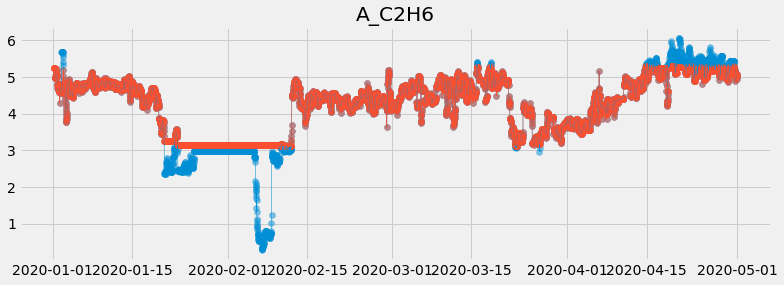

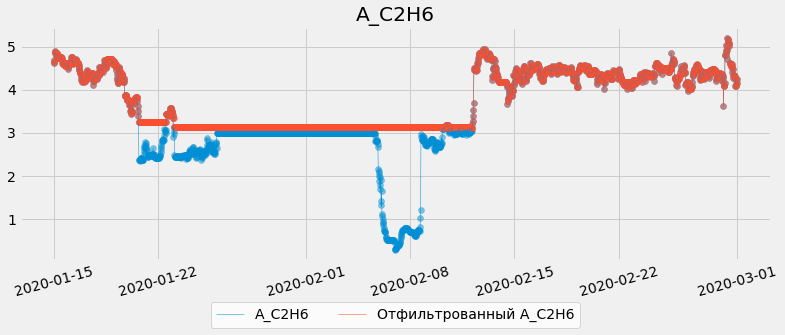

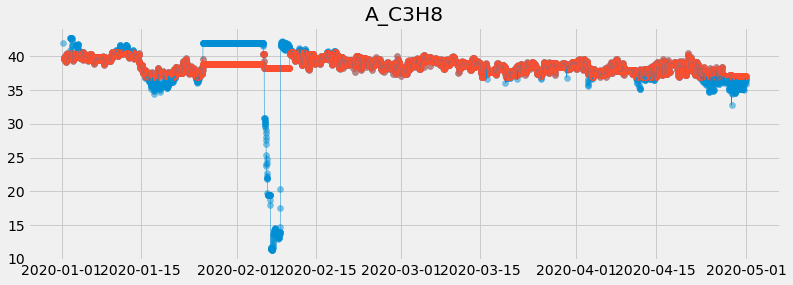

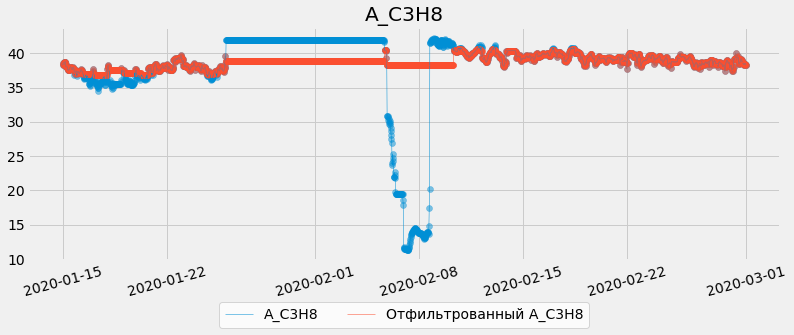

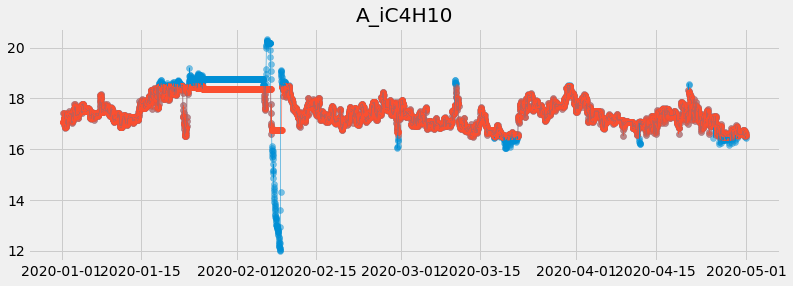

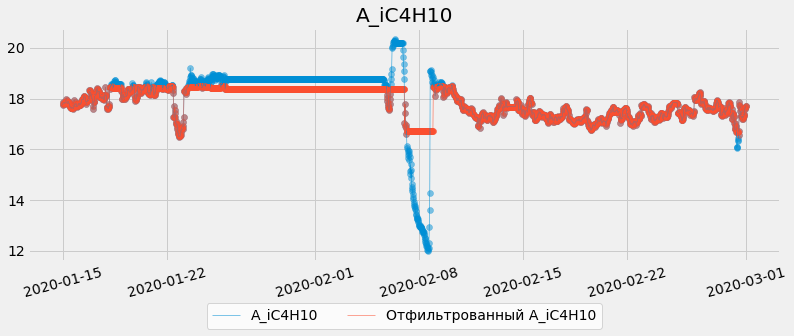

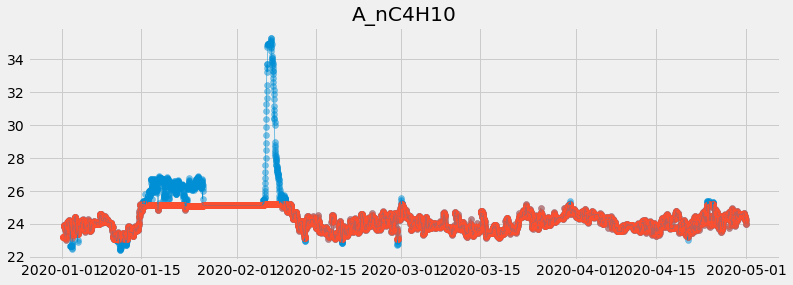

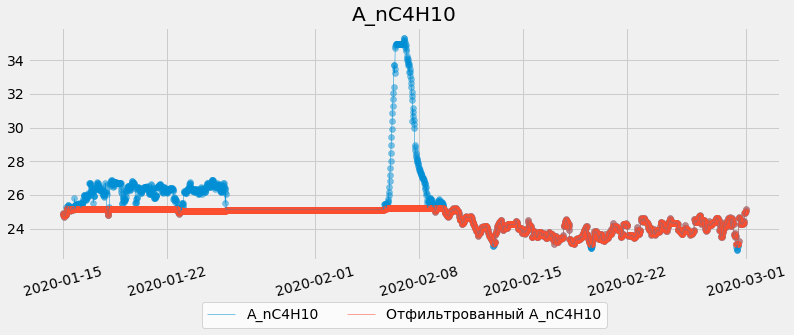

In [15]:
for feature in features:
    fast_plot(train_corrected[feature][:'2020-04'], title=feature)
    fast_plot(train[feature][:'2020-04'], new_figure=False)
    
    fast_plot(train_corrected[feature]['2020-01-15':'2020-02'], title=feature, label=feature)
    fast_plot(train[feature]['2020-01-15':'2020-02'], new_figure=False, label=f'Отфильтрованный {feature}')
    plt.xticks(rotation=15);
    plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.15), fontsize=14)
    plt.show()

In [12]:
# all features added since 12.12 1:24
train.to_csv('data/dataset_filtered_1.csv')

# Фильтрация №4

In [13]:
%%time
features = ['A_rate', 'B_rate', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10']
train = pd.concat([train_features, test_features])

train = train.fillna(method='ffill')
train['A'] = train['A_rate'].cumsum()
train['B'] = train['B_rate'].cumsum()

train = pd.merge(train, train_targets, left_index=True, right_index=True, how='outer')
train = train['2020-01-01 04:30:00':]

# Только рабочие фичи


Wall time: 15 ms


In [14]:
targets = train_targets.columns
features = ['A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10']

train_mask = ((train.index > '2020-02-15') & (train.index < '2020-03-19') & (train[targets].sum(axis=1) > 0)) | \
    ((train.index > '2020-03-22') & (train.index < '2020-04-06') & (train[targets].sum(axis=1) > 0))

train_targets_mask = ((train_targets.index > '2020-02-15') & (train_targets.index < '2020-03-19') &
                      (train_targets.sum(axis=1) > 0)) | \
                     ((train_targets.index > '2020-03-22') & (train_targets.index < '2020-04-06') & 
                      (train_targets.sum(axis=1) > 0))

### Коррекция колебаний

In [15]:
def get_threshold(data, quantiles):
    return data.diff().quantile(quantiles).abs().max()

def correct_data(data, quantiles_data, quantiles, rolling):
    treshold = get_threshold(quantiles_data, quantiles)
    data = data.copy()
    rolling_data = data.rolling(rolling).mean()
    mask = ((data.diff().abs() > treshold) | (data.diff(periods=2).abs() > treshold * 2)) 
    data[mask] = rolling_data[mask]
    return data  

In [16]:
train_corrected = train.copy()
for feature in features:
    train_corrected[feature] = correct_data(train_corrected[feature], 
                                            train_corrected[feature]['2020-01':'2020-03'], [0.05, 0.95], 10) 
    train_corrected[feature] = correct_data(train_corrected[feature], 
                                            train_corrected[feature]['2020-01':'2020-03'], [0.01, 0.99], 10) 

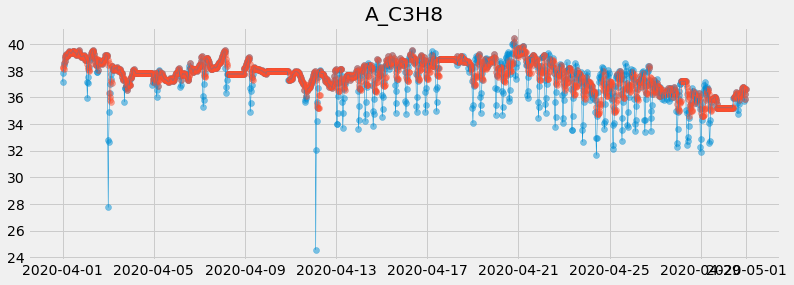

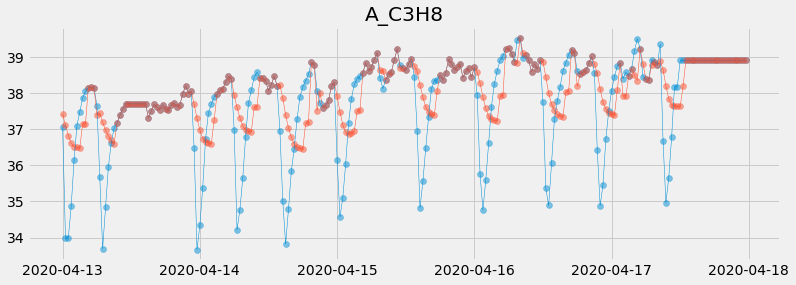

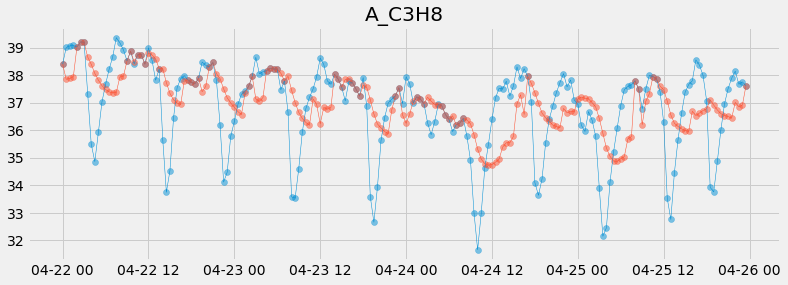

In [17]:
fast_plot(train['A_C3H8']['2020-04':'2020-04'], title='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04':'2020-04'], new_figure=False)

fast_plot(train['A_C3H8']['2020-04-13':'2020-04-17'], title='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04-13':'2020-04-17'], new_figure=False)

fast_plot(train['A_C3H8']['2020-04-22':'2020-04-25'], title='A_C3H8')
fast_plot(train_corrected['A_C3H8']['2020-04-22':'2020-04-25'], new_figure=False)

### Коррекция выбросов

In [18]:
train = train_corrected.copy()

In [19]:
low = 0.005
high = 0.995
A_C2H6_quantiles = train['A_C2H6'][train_mask].quantile([low, high]).values
A_C3H8_quantiles = train['A_C3H8'][train_mask].quantile([low, high]).values
A_iC4H10_quantiles = train['A_iC4H10'][train_mask].quantile([low, high]).values
A_nC4H10_quantiles = train['A_nC4H10'][train_mask].quantile([low, high]).values
print(A_C2H6_quantiles)
print(A_C3H8_quantiles)
print(A_iC4H10_quantiles)
print(A_nC4H10_quantiles)

train['A_C2H6'][(train['A_C2H6'] < A_C2H6_quantiles[0]) | (train['A_C2H6'] > A_C2H6_quantiles[1]) ] = np.NaN
train['A_C3H8'][(train['A_C3H8'] < A_C3H8_quantiles[0]) | (train['A_C3H8'] > A_C3H8_quantiles[1])] = np.NaN
train['A_iC4H10'][(train['A_iC4H10'] < A_iC4H10_quantiles[0]) | (train['A_iC4H10'] > A_iC4H10_quantiles[1])] = np.NaN
train['A_nC4H10'][(train['A_nC4H10'] < A_nC4H10_quantiles[0]) | (train['A_nC4H10'] > A_nC4H10_quantiles[1])] = np.NaN

display_series(train.isna().sum(), 'Nas count')
train = train.fillna(method='ffill')
display_series(train.isna().sum(), 'Nas count')

[3.11489246 5.29773668]
[36.89203847 40.6471807 ]
[16.48372008 18.49511603]
[23.03770932 25.22089675]


,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,A,B,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
Nas count,0,0,1628,2216,1499,884,0,0,0,0,0,0,4168,4164,4164,4164


,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,A,B,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
Nas count,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0


### Оценка результата

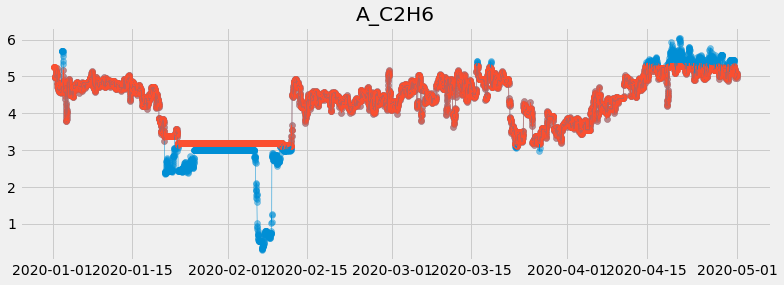

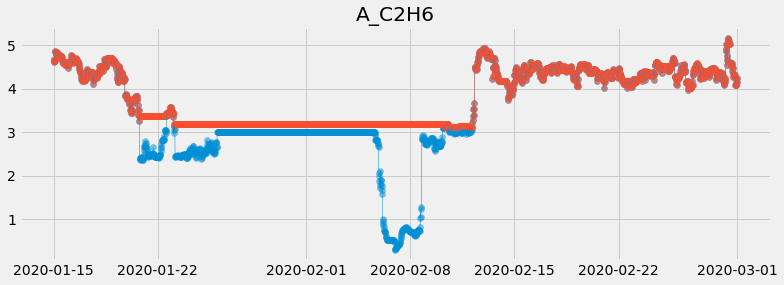

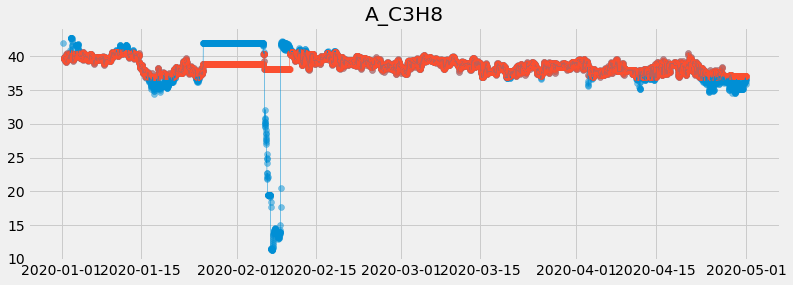

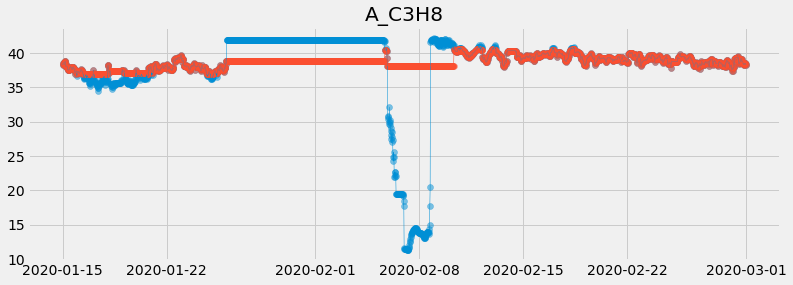

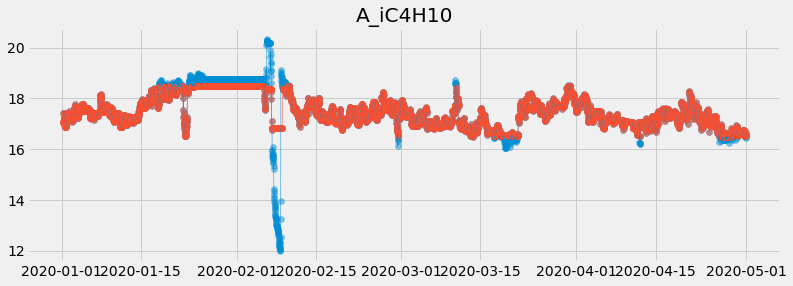

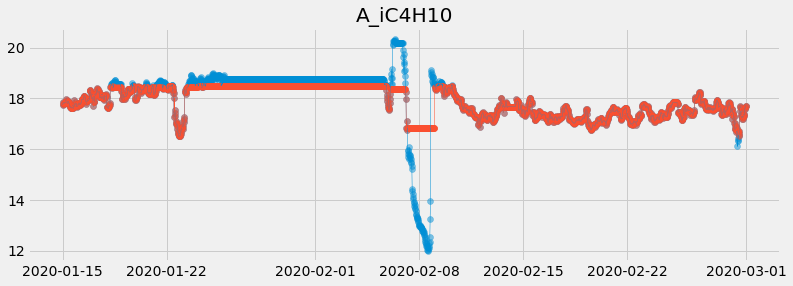

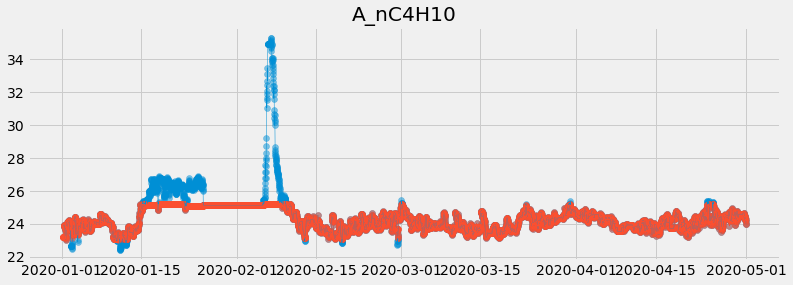

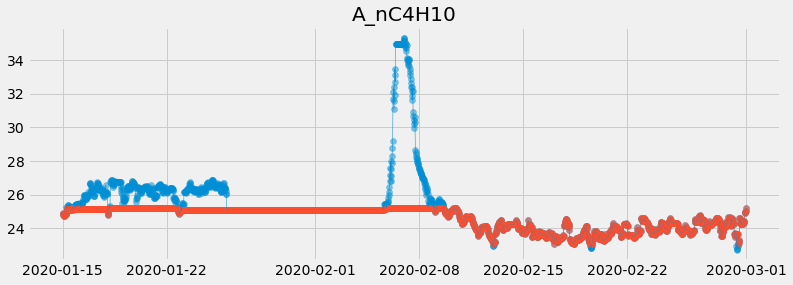

In [20]:
for feature in features:
    fast_plot(train_corrected[feature][:'2020-04'], title=feature)
    fast_plot(train[feature][:'2020-04'], new_figure=False)
    
    fast_plot(train_corrected[feature]['2020-01-15':'2020-02'], title=feature)
    fast_plot(train[feature]['2020-01-15':'2020-02'], new_figure=False)

In [21]:
train.to_csv('data/dataset_filtered_4.csv')